In this asignment, you will learn how to implement a very simple **Feedforward Neural Network from scratch**. You will work on this assigment in two weeks, the *forward* part will be implemented in the first one, and the *backward* part will be finished after the next lecture. However, you still need to submit two separate submissions (the later one will consist of the previous submission and the new implemented functions in the same notebook).


*Credits: The idea and some setup codes in this assignment are modified from Prof. Sanmi Koyejo's CS446/FA20 at UIUC*

## I. Dataset Preparation

**Task:** We will work on a simple *3-classes* classification problem on the [
UCI Wine Data Set](https://archive.ics.uci.edu/ml/datasets/wine). Given a set of features of a given wine bottle, can you predict the type of this bottle?

---

**P1:** Run the following cell to download the dataset, or use the link from the dataset page.

In [ ]:
array = [1,
         2,
         3]
print (array)

[1, 2, 3]


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#DOWNLOAD DATASET
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2021-05-04 15:39:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data.1’

wine.data.1         100%[===================>]  10.53K  --.-KB/s    in 0s      

2021-05-04 15:39:26 (41.3 MB/s) - ‘wine.data.1’ saved [10782/10782]





---

**P1:** Although the file extension is `.data`, it is just a normal text file. You will need to read the dataset description on the dataset page, extract out appropriate columns for all features and labels. 


1. Save all features to a variable called `X` and all labels to `y` as we did in the previous assignments.
2. Normalize all features

Hint: The shape of `X` and `y` should be (178,13) and (178,) respectively. You might want to have the datatype of `y` is `np.int` (using `ndarray.astype(...))`

In [ ]:
data=np.loadtxt("wine.data", delimiter=',')
X=data[:,1:]
y=data[:,0].astype(np.int)
X=(X-X.mean(axis=0))/X.std(axis=0)
print(X.shape)
print(y.shape)

(178, 13)
(178,)


**P1:** Now, you will need to implement a function called `to_one_hot(y, k)` to convert the labels from numeric values to [one hot vectors ](https://en.wikipedia.org/wiki/One-hot). Note that we are working with an multi-class classification problem, instead of represent the labels in a numeric formmat as $0, 1, 2, ... K$, we can use $K$-dimensional one-hot vector as it is more convenience. Only one element in an one hot vector will have value 1, the rest are zeros. As an example, for a 3-classes classification problem, class 0 is $[1,0,0]$, class 1 is $[0,1,0]$ and class 2 is $[0,0,1]$.

---

* Convert your labels into one-hot vectors, saved in `y_one_hot`.
* What is the shape of `y_one_hot`?

In [ ]:
def to_one_hot(y, k):
    """
    @brief      Convert numeric class values to one hot vectors
    @param      y     An array of labels of length N
    @param      k     Number of classes
    @return     A 2d array of shape (N x K), where K is the number of classes
    """
    n = y.shape[0]
    one_hot = np.zeros((n, k))
    one_hot[np.arange(n), y.astype(np.int) - 1] = 1
    return one_hot
y_one_hot=to_one_hot(y, 3)
print(y_one_hot.shape)

(178, 3)


## II. Feed Forward Neural Network Implementation

### II.1. Provided Functions & Modules:
For simplicity, we have provided several helper functions and modules. You need to know the meaning and input/output of each funnction. The understanding of **implement details are not required, but highly recommended**. If you have any questions regarding to them, please come to office hours.

In [ ]:
#PROVIDED FUNCTIONS, RUN THIS CELL
def clear_grad(model):
    """
    clear the gradient in the parameters and replace them with 0's
    """
    for name, param, grad in model.named_parameters():
        name_split = name.split(".")
        child_name = name_split[0]
        param_name = name_split[1]
        model.children[child_name].grads[param_name] = np.zeros_like(model.children[child_name].grads[param_name])

def weight_init(fan_in, fan_out):
    """
    @param      fan_in   The number of input units
    @param      fan_out  The number of output units
    @return     The 2d weight matrix initialized using xavier uniform initializer
    """
    a = np.sqrt(6.0/(fan_in + fan_out))
    return np.random.uniform(-a, a, size=(fan_out, fan_in))

class Module:
    def __init__(self):
        super().__init__()
        self.params = dict()
        self.grads = dict()
        self.children = dict()
        self.cache = dict()

    def _register_param(self, name: str, param: np.ndarray):
        """ the parameter can be accessed via self.params[name]
        the gradient can be accessed via self.grads[name]
        """
        assert isinstance(param, np.ndarray)
        self.params[name] = param
        self.grads[name] = np.zeros_like(param)

    def _register_child(self, name: str, child: 'Module'):
        """ the module can be acccessed via self.children[name]"""
        assert isinstance(child, Module)
        self.children[name] = child

    def forward(self, *x):
        raise NotImplementedError

    def backward(self, *g):
        raise NotImplementedError

    def named_parameters(self, base: tuple = ()):
        """recursively get all params in a generator"""
        assert self.params.keys() == self.grads.keys()
        for name in self.params:
            full_name = '.'.join(base + (name,))
            yield (full_name, self.params[name], self.grads[name])

        # recursively on others
        for child_name, child in self.children.items():
            yield from child.named_parameters(base=base + (child_name,))

### II. 2. Main Modules
*Please read this section careflully!*

The neural network layers should be implemented as different **Modules** with methods forward and backward to implement the forward computation process and the backpropagation gradient computation process. **The structure of Module is inspired by the popular deep learning framework `PyTorch`**.  In summary, for a module named `my_module`:

1. Parameter weight and bias can be accessed via `my_module.params['weight']` and `my_module.params['bias']`
2. Gradient of weight and bias can can be accessed via `my_module.grads['weight']` and `my_module.params['bias']`.
3. Child module `child_layer` can be accessed via `my_module.children['child_layer']`
4. `Module.forward` takes input `NumPy np.ndarray(s)` and generates the output np.ndarray(s) according the feedforward computation to be performed by this module.
5. `Module.backward` updates gradients across the module for the backpropagation process.
6. To save some intermediate results, `my_module.cache['param_name']` is a good place. 


Suppose you want to implement a feed-forward neural network, you can create a class called `NeuralNetwork`. This class is a `Module` (Inheritance). The network consists of 2 `Linear` transformations, one maps input-nodes into hidden-nodes and the second maps hidden-nodes to the output-nodes. The `Linear` objects here is also a `Module`, but they are components of `NeuralNetwork`. Hence, we called them *child module*. In addition, we also want to have the `ReLU` activation function, which is once again, a `Module` and a children of your `NeuralNetwork` class, without any parameter.

They follows the same interface, methods as their father - `Module`. By composing different module, we can create a *computational graph* which data can flow forward to get the output and gradient descent using chain-rule can flow backward to update the parameters. By following the same interface, you just need to implement some fundamental "blocks", and later, you can build a more complex structure using those blocks, easily. This is the beauty of object oriented programming.

---

Now you will implement your `ReLU`, `Linear` modules, and then your target `Neural Network` module!. In **P1**, you will complete the forward part and **P2** will be the backward. Later, when using `PyTorch`, you only need to implement the *forward*, and the *backward* is done automatically behind the scene by the framework! 

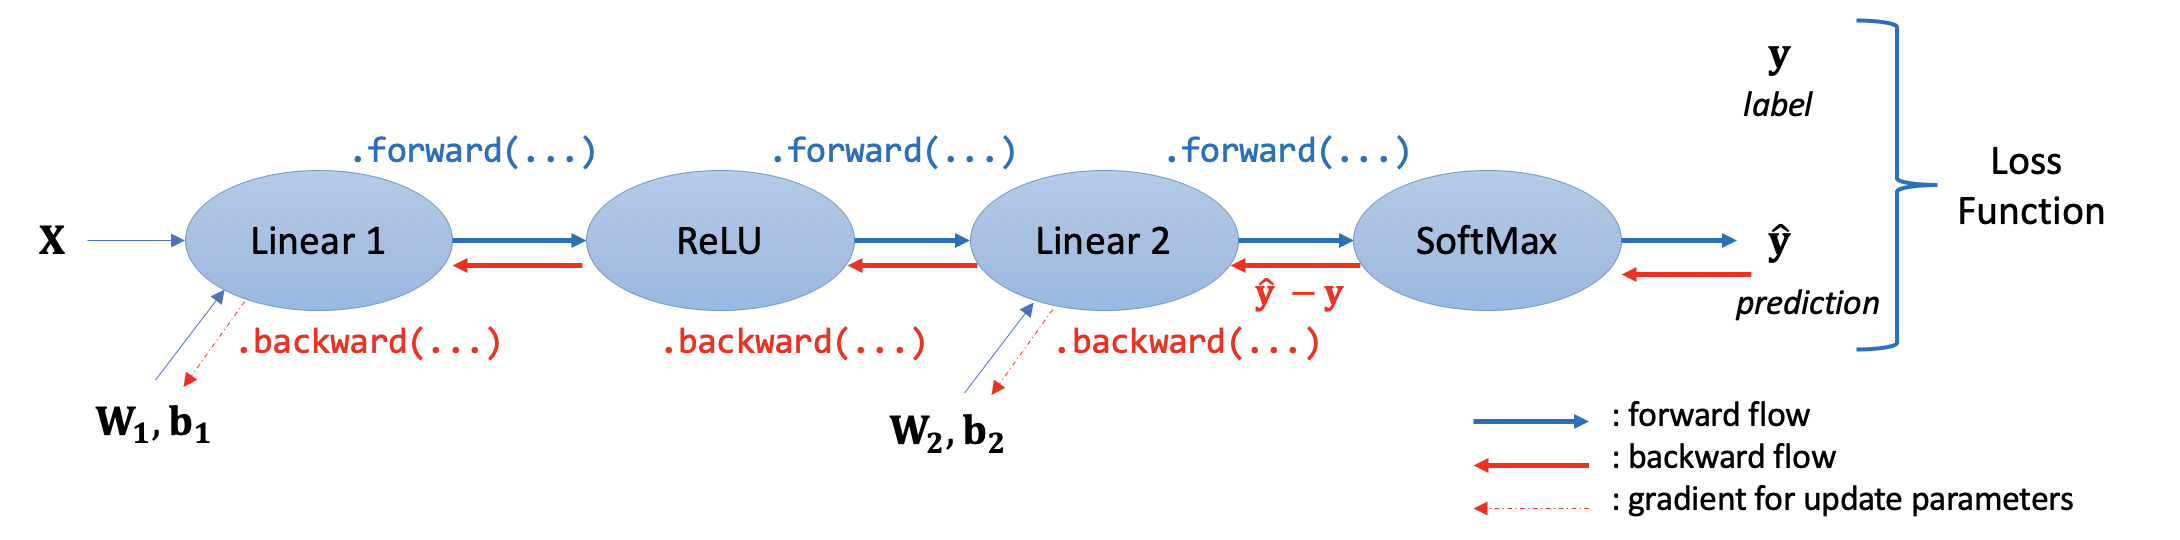

### II.3. ReLU Module 
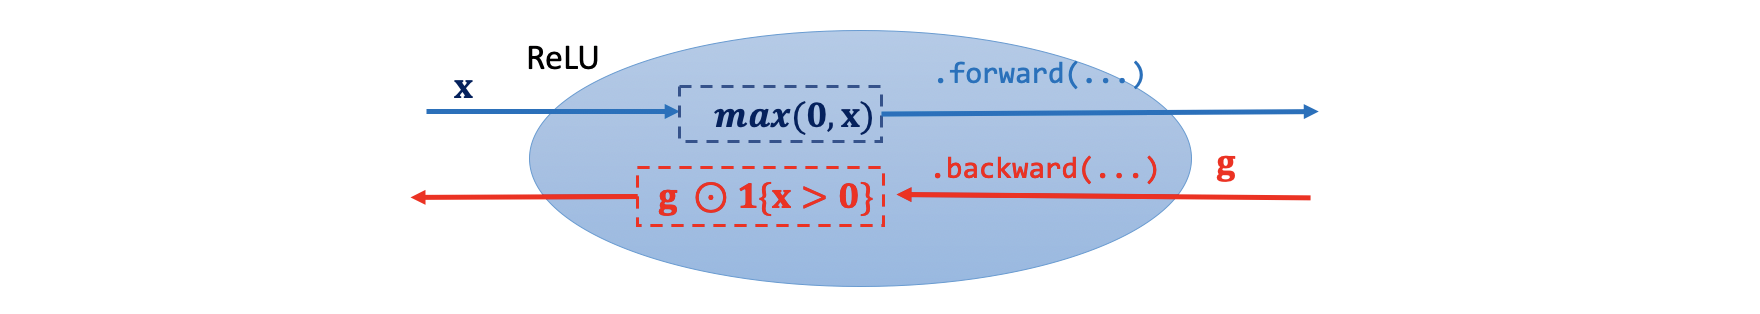


ReLU is the most commonly used activation function in neural network models. The function returns 0 if it recieves a negative input, but for any other values, it returns that value back. The ReLU function is given by:
$$
  \text{ReLU}(x) = \begin{cases} 0 \text{ if } x<0 \\ x \text{ otherwise} \end{cases}
$$
In backward and forward of ReLU module are given in the above figure. In the backward part, $\odot$ is element-wise multiplication and $\textbf{1}\{ \cdot \}$ is the indicator function, given by
$$
  \textbf{1}(x) = \begin{cases} 0 \text{ if } x<0 \\ 1 \text{ otherwise} \end{cases}
$$

---

* **P1:** Implement the `forward` function.
* **P2:** Implement the `backward` function. Hint: you should save the input value in the `forward` function to `self.cache['x']`, it will decide the value of the gradient values.


In [ ]:
class ReLU(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        @brief      Takes a batch of input and compute the ReLU output
        @param      x     A numpy array as input (N, in_features)
        @return     The output at the ReLU layer (N, in_features)
        """
        self.cache['x']=x
        def relu(x):
            if x<0:
                return 0
            return x
        reluv = np.vectorize(lambda x: relu(x))
        return reluv(x)

    def backward(self, g):
        """
        @brief      Compute the gradients for parameters
        @param      g     The gradient of previous layers
        @return     The gradients of the loss w.r.t the input of this layer
        """
        def _1(x):
            if x<0:
                return 0
            return 1
        _1v = np.vectorize(lambda x: _1(x))
        return g*_1v(self.cache['x'])

#Sanity Check
rl = ReLU()
print(rl.forward(np.array([0.2, -0.4, 1.2])))  #Output: [0.2 0.  1.2]
print(rl.backward(np.array([-0.1, 0.4, -0.2])))#Output: [-0.1  0.  -0.2]

[0.2 0.  1.2]
[-0.1  0.  -0.2]


### II.4. Linear module
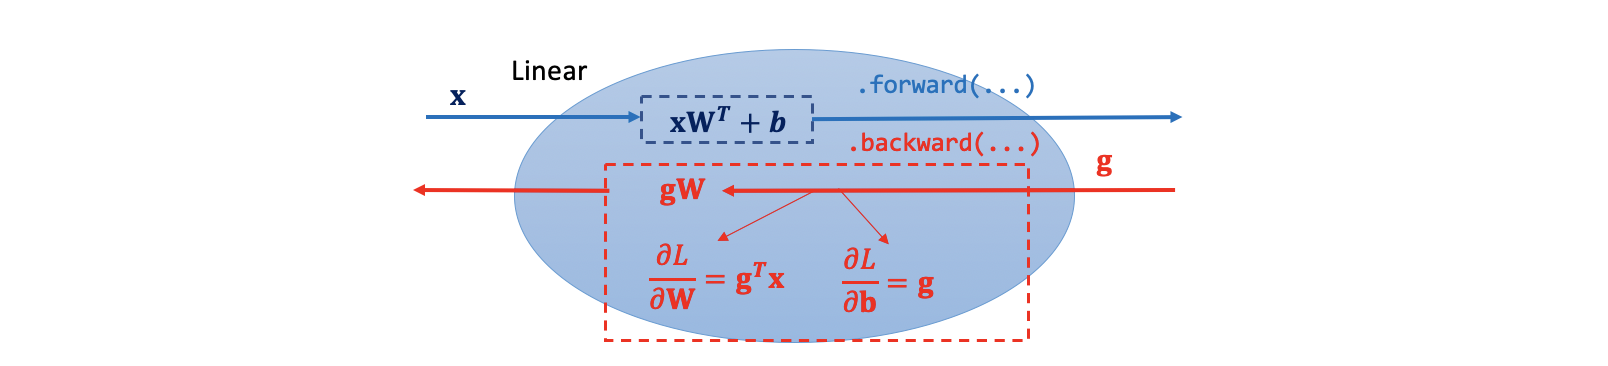

This module applies a linear transformation to the incomming data:
$$
\textbf{y} = \textbf{xW}^\top + \textbf{b}
$$

In the `backward` function, besides returing the gradient, we also need to calculate derivative of the loss function w.r.t. $\textbf{W}$ and $\textbf{b}$ for updating the values. You should save the gradients in `self.grads['weight']` and `self.grads['bias']` separately. All the formulas have already been given.

Becareful that the formulas are given for one vector $\textbf{x}$ (shape $1\times D$, where $D$ is the dimension). However, In this implementation, both $\textbf{x}$ and $\textbf{g}$ refer to a "batch" of samples (in this case, ALL samples in the training set, having the shape of $N \times D$ where $N$ is the number of training samples). **We need to sum up the values across all training samples.** It does not matter for the term $\textbf{g}^\top\textbf{x}$ since $(K\times N) \times (N \times D)$ has already sum up the values, implicitly in the matrix multiplication. You need to take care of the gradient for the bias term. (Hint: what is the shape of the gradient w.r.t $\textbf{b}$ should be?)

---

* **P1:** Implement the `forward` function.
* **P2:** Implement the `backward` function. Hint: you should save the input value `x` in the `forward` function to `self.cache['x']`



In [ ]:
class Linear(Module):
    def __init__(self, weight, bias):
        super().__init__()
        self._register_param('weight', weight) #(in_features x out_features)
        self._register_param('bias', bias) #(1, out_features)

    def forward(self, x):
        """
        @brief      Takes a batch of input and compute the linear output
        @param      x     A numpy array as input (N, in_features)
        @return     The output of the linear layer (N, out_features)
        """
        self.cache['x']=x
        return x.dot(self.params['weight'].T)+self.params['bias']

    def backward(self, g):
        """
        @brief      Compute the gradients for parameters
        @param      g     The gradient of previous layers (N, out_features)
        @return     The gradients of the loss w.r.t the input of this layer (N, in_features)
        """
        x=self.cache['x']
        self.grads['weight']=g.T.dot(x)
        self.grads['bias']=g.sum(axis=0)
        return g.dot(self.params['weight'])

#Sanity Check
w  = np.array([[1.2,0.1,-0.3], [-1.1,0.8,0.5]])
b  = np.array([0.2, -0.1])
ln = Linear(w, b)
print(ln.forward(np.array([[-1.1, 0.6, -1.3],[1.3, -0.6, -0.9]])))  #output: [[-0.67  0.94][ 1.97 -2.46]]
print(ln.backward(np.array([[-1.2, 2.0],[-1.4, 1.0]])))  #output: [[-3.64  1.48  1.36] [-2.78  0.66  0.92]]
print(ln.grads['weight']) #output: [[-0.5   0.12  2.82] [-0.9   0.6  -3.5 ]]
print(ln.grads['bias'])   #output: [-2.6  3. ]

[[-0.67  0.94]
 [ 1.97 -2.46]]
[[-3.64  1.48  1.36]
 [-2.78  0.66  0.92]]
[[-0.5   0.12  2.82]
 [-0.9   0.6  -3.5 ]]
[-2.6  3. ]


### II.5. NeuralNetwork Module
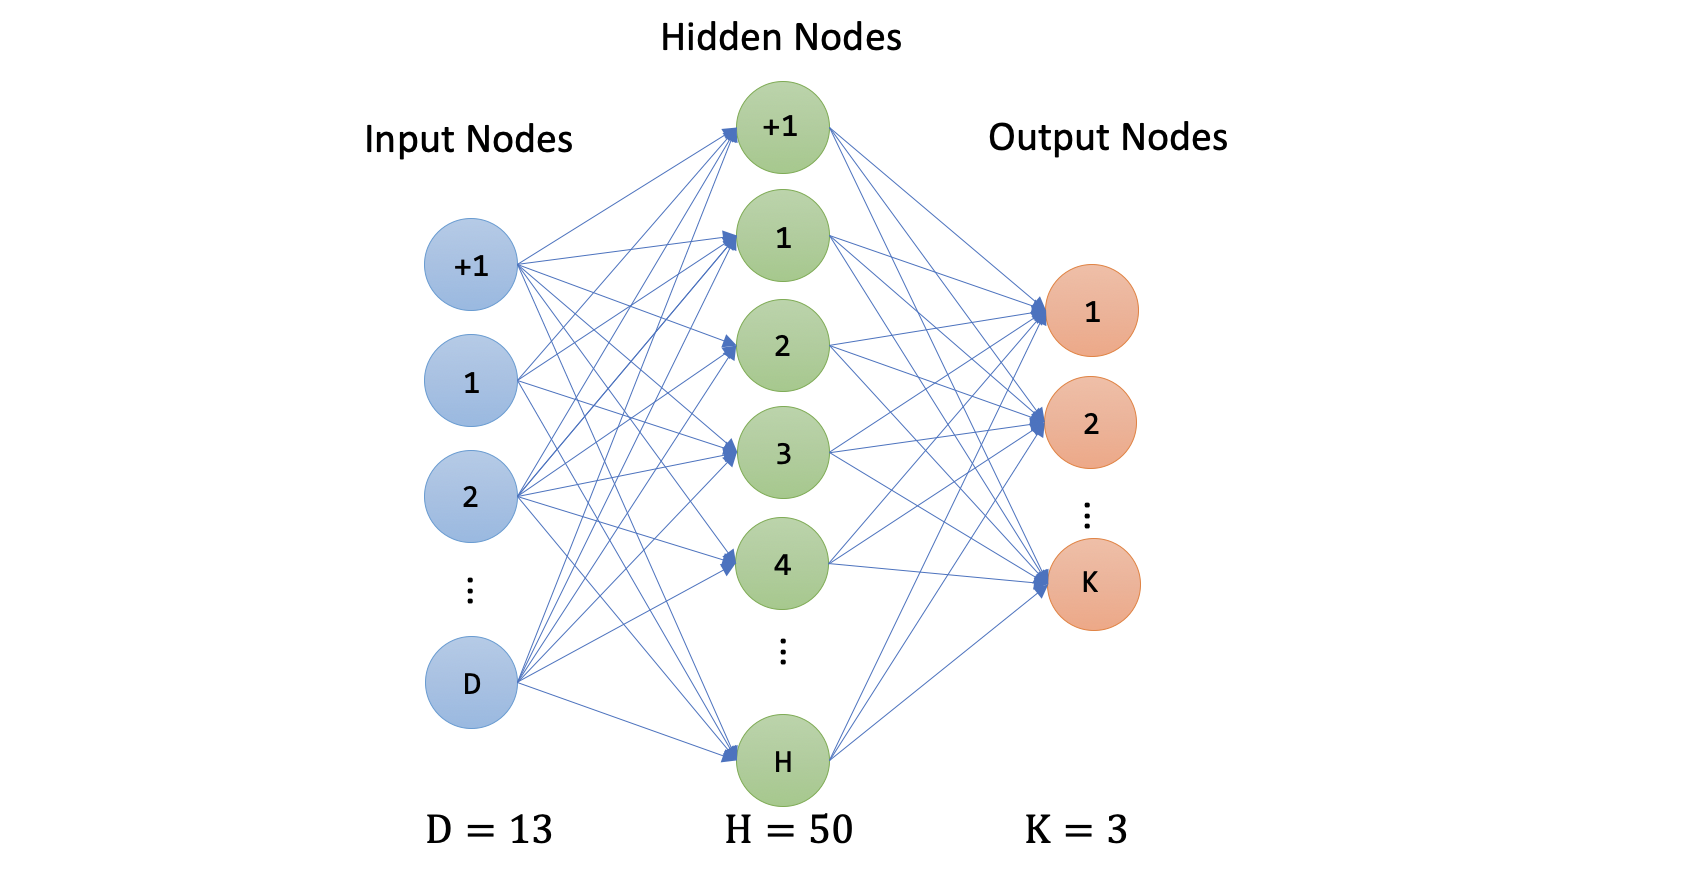

Now we will implement the `Neural Network` (NN) module, using `ReLU` and `Linear` blocks that we had in the previous parts. Besides the input layer, our simple neural network will have only one hidden layer and one output layer. As an example, in the later parts, we will create a NN with the input layer has $D = 13$ nodes, hidden layer has $H = 50$ nodes and output layer has $K = 3$ nodes. We implemented the `__init__` function for you. Here are some details:
* Firstly, initialize the weight for `w1,b1,w2,b2`, they are weights and biases of our model. `w1,b1` will transform input nodes to hidden nodes and `w2,b2` will transform hidden nodes to the output nodes.
* Secondly, adding two layers `Linear1` and `Linear2` to our NeuralNetwork module. If you want to get these layers, using `self.children['Linear1']` or `self.children['Linear2']`.
* Finally, adding an activation layer, we will use ReLU for our network. Whenever you need an activation layer, let's call `self.children['ReLu']`.

---
**P1**: Implement the `forward` function, using the following instructions:
* The `forward` function will take a NumPy array `x` as input. It is your input nodes. 
* Firstly, take `x` as the input of the forward function of `Linear 1`
* Secondly, Take the output of the previous step goes through the `ReLU` function
* Thirdly, take the output of the previous step as the input of the forward function of `Linear 2`
* Lastly, return the output of the previous step

**P2**:
Implement the `backward` function, using the following instructions:
* The `backward` function will take two input NumPy array `y, y_hat`. `y` is the label and `y_hat` is the prediction from your model.
* The gradient flow from the softmax and loss function has already been given to you in the overall graph as $\hat{\textbf{y}} - \textbf{y}$.
* Using the `backward` function of each children to complete the `backward` function of `NeuralNetwork` module.

In [ ]:
class NeuralNetwork(Module):
    def __init__(self, d, h, k):
        """
        @brief      Initialize weight and bias
        @param      d     size of the input layer
        @param      h     size of the hidden layer
        @param      k     size of the output layer
        """
        super().__init__()
        wb = weight_init(d + 1, h)
        w1 = wb[:, :d]
        b1 = wb[:, d]
        wb = weight_init(h + 1, k)
        w2 = wb[:, :h]
        b2 = wb[:, h]
        self._register_child('Linear1', Linear(w1, b1))
        self._register_child('Linear2', Linear(w2, b2))
        self._register_child('ReLU', ReLU())

    def forward(self, x):
        """
        @brief      Takes a batch of samples and compute the feedforward output
        @param      x     A numpy array of shape (N x D)
        @return     The output at the last layer (N x K)
        """
        x=self.children['Linear1'].forward(x)
        x=self.children['ReLU'].forward(x)
        x=self.children['Linear2'].forward(x)
        return x
        
    def backward(self, y, y_hat):
        """
        @brief      Compute the gradients for Ws and bs, you don't
                    need to return anything
        @param      y      ground truth label of shape (N x K)
        @param      y_hat  predictions of shape (N x K)
        """
        x=y_hat-y
        x=self.children['Linear2'].backward(x)
        x=self.children['ReLU'].backward(x)
        x=self.children['Linear1'].backward(x)

#Sanity Check
np.random.seed(1606)
nn = NeuralNetwork(2,4,2)
print(nn.forward(np.array([[0.1, -0.4],[0.5, 0.2]]))) #Output: [[-0.49234962 -0.56357774][-0.57693508 -0.8204212 ]]
nn.backward(np.array([[1,0],[0,1]]), np.array([[0.4,0.6],[0.2,0.8]]))
print(nn.children['Linear1'].grads["bias"])           #Output: [-0.045261  ,  0.41621085,  0.29340559,  0.    ]

[[-0.49234962 -0.56357774]
 [-0.57693508 -0.8204212 ]]
[-0.045261    0.41621085  0.29340559  0.        ]


##III. Neural Network Learning

### III.1. Soft-max Function
The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) takes as input a vector $\textbf{z}$ of $K$ real numbers, and normalizes it into a probability distribution consisting of K probabilities proportional to the exponentials of the input number. For element $i$ in an input vector $\textbf{z}$:
$$
\text{softmax}(\textbf{z})_i  = \frac{e^{\textbf{z}_i}}{\sum_{j=1}^K e^{\textbf{z}_j}}
$$
It's clear that each element in the output vector is a positive number smaller than 1 and all sum to 1. For numerical stability, we should **subtract each element with the largest element in the input vector** (you can try to show that it does not affect the results, mathematically).

---  

**P1:** Implement the `softmax(x)` function

In [ ]:
def softmax(x):
    """
    A numerically stable version of the softmax function
    @param      x     A NumPy array of shape (D,)
    @return     The output after the softmax layer (D,)
    """
    return np.exp(x)/(np.exp(x).sum())

#Provided function, apply your softmax function to every row of a matrix X
def batch_softmax(x):
    return np.apply_along_axis(softmax, 1, x)

#Sanity check
softmax(np.array([8.6, -3.1, 2.4])) #output: [9.97966419e-01, 8.27695301e-06, 2.02530363e-03]

array([9.97966419e-01, 8.27695301e-06, 2.02530363e-03])

### III.2. Finding the Accuracy of Your Model
To evaluate the performance of your model, we will use the **classification accuracy** metric. It is determined by the ratio of number of correct predictions to the total number of input samples.
You implemented the `softmax` function, which can help you to map the outputs of your model into a probability distribution. To get the final prediction, we just need to select the index of the element having the largest value inside the softmax vector. 

---

**P1:** Implement the ` accuracy(y, y_hat)` function. This function takes two input agruments, `y` and `y_hat` are both $N \times K$ matrix ($N$ is the number of samples and $K$ is the number of classes). Each row of `y` is a label in one-hot vector representation while each row of `y_hat` is an output from the softmax function. 

Hint: you can use `np.argmax` to find the index of the largest element on each row of `y` and `y_hat`, and then compare all the values whether they are match or not. Return the ratio of the number of correct predictions over the total number of samples. 

In [ ]:
def accuracy(y, y_hat):
    """
    @param      y      ground truth labels of shape (N x K)
    @param      y_hat  Estimated probability distributions of shape (N x K)
    @return     the accuracy of the prediction as a scalar
    """
    return (np.argmax(y, axis=1)==np.argmax(y_hat, axis=1)).sum()/len(y)
    return None

#Sanity check
print(accuracy(np.identity(2), np.array([[0.8,0.2],[0.9,0.1]]))) #Output: 0.5

0.5


####III.3. `update_param` Function
This function will help you to update the parameters of the network, using gradient descent

---

**P2:** Implement the `update_param` function, using the following instructions:
* The `update_param` function will take your model and a learning rate as two inputs.
* You will need to update the value of the `weight` and `bias` of each linear layer seperately. There are two linear layers, totally you will need to have 4 updates. 
The update rule for the weight term is (just like gradient descent updates as you did in previous lab assignments):
$$
\mathbf{W}_{t+1} = \mathbf{W}_{t} - \frac{\alpha}{N}\sum_{i=1}^N \cfrac{\partial \text{Err}^{(i)}}{\partial \mathbf{W}}
$$
and similiar to the bias term:
$$
\mathbf{b}_{t+1} = \mathbf{b}_{t} - \frac{lr}{N}\sum_{i=1}^N \cfrac{\partial\text{Err}^{(i)}}{\partial \mathbf{b}}
$$
The implementation is simple. You have already had all values and the gradients stored in each `Module`. For example, the weight of `Linear1` can be accessed by: `model.children['Linear1'].params['weight']` and its gradient by `model.children['Linear1'].grads['weight']`.
* You just need to multiply by `lr` and do the subtraction. **Important note: You don't need to divide by N in this function**. We will assume that the value of `lr` passed into the function had already been devided by the total number of samples $N$ (check the `train_one_epoch` function in the next part). 


In [ ]:
def update_param(model, lr):
    """
    update the parameters of the network
    """
    for m in ['Linear1', 'Linear2']:
        model.children[m].params['weight']-=model.children[m].grads['weight'].sum(axis=0)*lr
        model.children[m].params['bias']-=model.children[m].grads['bias']*lr
    pass

### III.4. Train One Epoch
There are certain steps that need to be completed for one-epoch training. We have provided the codes for each step, but they are not in a right order.


1.   ```
#Clear gradients
clear_grad(model)
```
2.   
```
#Compute train accuracy
train_accuracy = accuracy(y, y_hat_train)
loss = cost(y, y_hat_train)
```
3.
```
#Compute test accuracy
# y_hat_test  = batch_softmax(model.forward(test_x))
test_accuracy = accuracy(test_y, y_hat_test)
return train_accuracy, test_accuracy
```
4.
```
#Feed forward and compute y_hat
y_hat_train = batch_softmax(model.forward(x))
```
5.
```
#Do back propagation and update weights
model.backward(y, y_hat_train)
batch_size = y.shape[0]
update_param(model, lr / batch_size)
```

---

**P2:** Based on your understanding of each function, copy and paste them in the right order into the `train_one_epoch` function below.


In [ ]:
def cost(y, y_hat):
    return -np.sum(y*np.log(y_hat))/y.shape[0]

def train_one_epoch(model, x, y, test_x, test_y, lr):
    """
    @brief      Takes in a model and train it for one epoch.
    @param      model   The neural network
    @param      x       The features of training data (N x D)
    @param      y       The labels of training data (N x K)
    @param      test_x  The features of testing data (M x D)
    @param      test_y  The labels of testing data (M x K)
    @param      lr      Learning rate
    @return     (train_accuracy, test_accuracy), the training accuracy and
                testing accuracy of the current epoch
    """

    # Clear gradients
    clear_grad(model)

    # Feed forward and compute y_hat
    y_hat_train = batch_softmax(model.forward(x))

    # Do back propagation and update weights
    model.backward(y, y_hat_train)
    batch_size = y.shape[0]
    update_param(model, lr / batch_size)



    # Compute train accuracy
    train_accuracy = accuracy(y, y_hat_train)
    loss = cost(y, y_hat_train)

    # Compute test accuracy
    y_hat_test  = batch_softmax(model.forward(test_x))
    test_accuracy = accuracy(test_y, y_hat_test)
  


    return train_accuracy, test_accuracy

### III.5. Training - Testing Set Splitting
For reproducibility, we have selected 30 samples for testing and the rest are used for training. In the the following cell, `indices` is a binary NumPy array where an element **is `True` if it is a training sample**. We used that array to create a training set in `training_data` and `training_label`. 

**P2**: Complete the codes for the testing data. Hint: you will find `np.logical_not(...)` helpful.

In [ ]:
indices = np.ones(len(y_one_hot),dtype= bool)
indices[10:21] = False
indices[60:71] = False
indices[131:141] = False

training_data = X[indices]
training_label = y_one_hot[indices]

testing_data = X[np.logical_not(indices)]
testing_label = y_one_hot[np.logical_not(indices)]

### III.6. Training Your First Neural Network
**P2**: Now, it is the time for you to put everything together. 
* Create your model using `nn_model = NeuralNetwork(D, H, K)`. Your network should have 13 input nodes, 50 hidden nodes and 3 output nodes.
* We have provided the `train_val(nn_model, lr, n_epochs)` function to help you to train your model with a given learning rate `lr` for `n_epochs`. We suggest you can train your model with 100 epochs.
* This function can also plot out the Training and Testing accuracy. 
* Try training your model with $\alpha \in \{0.03,0.3,3\}$ and observe the training and testing accuracy.
* Among thouse values, what is the best $\alpha$?, briefly explain why the other two learning rates don't work well.

Learning Rate = 3.00 | Best Train Acc = 0.9178 | Best Test Acc = 0.8125


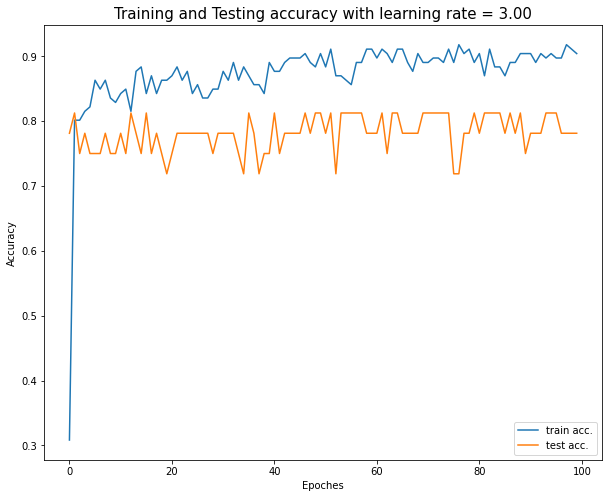

In [ ]:
def train_val(nn_model, lr, n_epochs = 100):
    train_acc = []
    test_acc  = []

    for i in range(n_epochs):
        tr_acc, te_acc = train_one_epoch(nn_model, training_data, y, testing_data, test_y, lr)
        train_acc.append(tr_acc)
        test_acc.append(te_acc)
        #print(tr_acc, te_acc)
    train_acc = np.array(train_acc)
    test_acc = np.array(test_acc)
    print("Learning Rate = %.2f | Best Train Acc = %.4f | Best Test Acc = %.4f" % (lr, train_acc.max(), test_acc.max()))
    plt.figure(figsize=(10,8))
    plt.plot(train_acc, label="train acc.")
    plt.plot(test_acc,  label="test acc.")
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Testing accuracy with learning rate = %.02f" % lr, size=15)

y      = training_label
test_y = testing_label

nn_model = NeuralNetwork(13, 50, 3)
train_val(nn_model, 3, 100)

#Sanity check:
#Your best training and testing accuracy should be close (or maybe equal) to 100%
#lr=3 seems to be the best (of all the given value). lr=0.03 or 0.3 take too long to converge and
#often get stuck on random local maximums